## Topic Modeling — With Tomotopy

LDA topic modeling in women's corpus of correspondance of the 18th Centrury sourced from Founders Online Database. 

### Import Pachages

In [152]:

import pandas as pd
import tomotopy as tp # for toping modeling
import little_mallet_wrapper # for functions concerning topic modeling
import seaborn # for statistical visualization
import glob # for finding pathnames
from pathlib import Path # for filesystem paths with semantics appropriate for different operating systems
import pandas as pd # for data wrangling 
import matplotlib.pyplot as plt #for plotting and visualization

### Data Preprocessing

In [153]:
# load dataset and inspect
df = pd.read_csv('women_corpus.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0.1      5517 non-null   int64 
 1   Unnamed: 0        5517 non-null   int64 
 2   title             5517 non-null   object
 3   permalink         5517 non-null   object
 4   project           5517 non-null   object
 5   authors           5517 non-null   object
 6   recipients        5443 non-null   object
 7   date_from         5517 non-null   object
 8   date_to           5517 non-null   object
 9   api               5517 non-null   object
 10  og_text           5516 non-null   object
 11  text              5516 non-null   object
 12  period            5517 non-null   object
 13  gender            5517 non-null   object
 14  recipient_gender  5517 non-null   object
dtypes: int64(2), object(13)
memory usage: 646.7+ KB


In [154]:
df.drop_duplicates(subset=['text'], inplace=True)
df.dropna(subset=['text'], inplace =True)

### Clean Data

In [155]:
# Function to detect language
from langdetect import detect
def is_not_french(text):
    try:
        return detect(text) != 'fr'
    except:
        return True  # Handle cases where detection fails

# Apply the function to filter out French texts
df_cleaned = df[df['text'].apply(is_not_french)]

In [156]:
import nltk
from nltk.corpus import stopwords
import string
import re
from hashlib import sha256

nltk.download('stopwords')

stop_words = stopwords.words('english')
# Process text
# Define the unnecessary syntax to remove and some words that occured in the model and are not representative:
text_to_remove =  [
    'mr', 'mrs', 'sir', 'dear', 'tho', 'letter', 'tell', 'write', 'shall',
    'franklin', 'et', 'vous', 'que', 'le', 'je', 'des', 'la', 'en', 'monsieur',
    'dr', 'il', 'mon', 'pour', 'che', 'non', 'di', 'mi', 'friend', 'think', 'day',
    'said', 'great', 'know', 'hope', 'good', 'say', 'john', 'benjamin', 'leter', 'adams', 'time', 'letters',
    'upon', 'would', 'may', 'send', 'much', 'well', 'two', 'see', 'one', 'must', 'last',
    'little', 'says', 'make', 'could', 'per', 'sua', 'con', 'und', 'uns', 'lui', 'cranch', 'smith', 'tis', 'till','hear', 'thing', 'many', 'wou','untill', 'verey', 
    'shee', 'aney', 'thay', 'est', 'pas','qui', 'les', 'une', 'bien', 'dans', 'votre', 'plus' ,'nous' ,'avec','get' ,'let' ,'take' ,'want' ,'done' ,'better', 'att', 'capt'
]
def preprocess_text(text):
    # Make everything lowercase
    text = text.lower()
    # Remove punctuation
    text = "".join(char for char in text if char not in string.punctuation)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # Remove numbers
    text = little_mallet_wrapper.process_string(text, numbers='remove')
    # Remove unnecessary words
    text = ' '.join(word for word in text.split() if word not in text_to_remove)
    return text

def hash_text(text):
    return sha256(text.encode('utf-8')).hexdigest()

# Process and hash texts
processed_texts = []
hashed_texts = set()
original_texts = []
titles = []
periods = []

for index, row in df_cleaned.iterrows():
    text = row['text']
    processed_text = preprocess_text(text)
    text_hash = hash_text(processed_text)

    if text_hash not in hashed_texts:
        hashed_texts.add(text_hash)
        processed_texts.append(processed_text)
        original_texts.append(text)
        titles.append(row['authors'])
        periods.append(row['period'])

# Verify lengths after preprocessing
print(f"Lengths after preprocessing: {len(processed_texts)}, {len(original_texts)}, {len(titles)}")

# Rebuild df_cleaned to ensure consistency
df_cleaned = pd.DataFrame({
    'text': original_texts,
    'authors': titles,
    'processed_text': processed_texts,
    'period': periods
})

# Deduplicate df_cleaned based on the processed_text column
df_cleaned['text_hash'] = df_cleaned['processed_text'].apply(hash_text)
df_cleaned = df_cleaned.drop_duplicates(subset='text_hash').drop(columns='text_hash')

# Verify lengths after deduplication
print(f"Length of df_cleaned after deduplication: {len(df_cleaned)}")

# Use processed_texts for topic modeling (after deduplication)
processed_texts = df_cleaned['processed_text'].tolist()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lengths after preprocessing: 5198, 5198, 5198
Length of df_cleaned after deduplication: 5198


## Train Topic Model
We’re going to train our topic model with the tp.LDAModel() function, which provides Latent Dirichlet Allocation(LDA) topic modelling. Its implementation is based on following papers:

* Blei, D.M., Ng, A.Y., &Jordan, M.I. (2003). Latent dirichlet allocation.Journal of machine Learning research, 3(Jan), 993 - 1022.
* Newman, D., Asuncion, A., Smyth, P., &Welling, M. (2009). Distributed algorithms for topic models. Journal of Machine Learning Research, 10(Aug), 1801 - 1828.

In [158]:
# Number of topics to return
num_topics = 38
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in processed_texts:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 100
for i in range(0, 1000, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')


Topic Model Training...


Iteration: 0	Log-likelihood: -9.538287741517898
Iteration: 100	Log-likelihood: -9.440130011523923
Iteration: 200	Log-likelihood: -9.385031846422901
Iteration: 300	Log-likelihood: -9.350444596711457
Iteration: 400	Log-likelihood: -9.32445865796286
Iteration: 500	Log-likelihood: -9.3118906016212
Iteration: 600	Log-likelihood: -9.301580212181317
Iteration: 700	Log-likelihood: -9.295613444616363
Iteration: 800	Log-likelihood: -9.289285019733283
Iteration: 900	Log-likelihood: -9.283490466335275


In [159]:
# Save the trained model
model.save('lda_model.bin', True)  # The second argument is to overwrite if the file exists
print("Model saved successfully!")
loaded_model = tp.LDAModel.load('lda_model.bin')
print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!


## Display Topics and Top Words
To examine the 15 topics that the topic model extracted from theWomen Correspondance Corpuss, run the cell below.

Take a minute to read through every topic. Reflect on what each topic seems to capture as well as how well you think the topics capture the broad themes of the entire collection. Note any oddities, outliers, or inconsistencies.

In [160]:
# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

sister cousin betsy love week braintree doctor receiv miss aunt

✨Topic 1✨

sister peabody though atkinson abby shaw son cousin love haverhill

✨Topic 2✨

caroline quincy susan harriet father sent george morning louisa like

✨Topic 3✨

house money year hundred pay dollors pounds purchase wood bill

✨Topic 4✨

mother stevenson water street hewson addressed air receiv self blunt

✨Topic 5✨

cylinder cotton teeth machine side parker end breastwork clearer fig

✨Topic 6✨

papa randolph adieu grand monticello believe daughter mama children dearest

✨Topic 7✨

mind nature love thy yet virtue world heart knowledge youth

✨Topic 8✨

god wee wich president grate der work das van nicht

✨Topic 9✨

addressed paris excellency london beg servant england humble paradise honour

✨Topic 10✨

life heart death heaven children feel years mind loss friends

✨Topic 11✨

lei jefferson america pini del appleton mia una mais mio

✨Topic 12✨

pleasure health friends family ma

Number of Topics: 1, Coherence Score: 0.37895349115133287
Number of Topics: 2, Coherence Score: 0.387337039411068
Number of Topics: 3, Coherence Score: 0.41274442325035726
Number of Topics: 4, Coherence Score: 0.5001751828938723
Number of Topics: 5, Coherence Score: 0.46816166132688525
Number of Topics: 6, Coherence Score: 0.49079283078511554
Number of Topics: 7, Coherence Score: 0.5215362912842206
Number of Topics: 8, Coherence Score: 0.5287176895886659
Number of Topics: 9, Coherence Score: 0.5887972217467096
Number of Topics: 10, Coherence Score: 0.5551465670019389
Number of Topics: 11, Coherence Score: 0.5493636242368004
Number of Topics: 12, Coherence Score: 0.5520113493005434
Number of Topics: 13, Coherence Score: 0.5492350743367121
Number of Topics: 14, Coherence Score: 0.62090166083404
Number of Topics: 15, Coherence Score: 0.6078453735572596
Number of Topics: 16, Coherence Score: 0.6779228826984763
Number of Topics: 17, Coherence Score: 0.6811917436035242
Number of Topics: 18, 

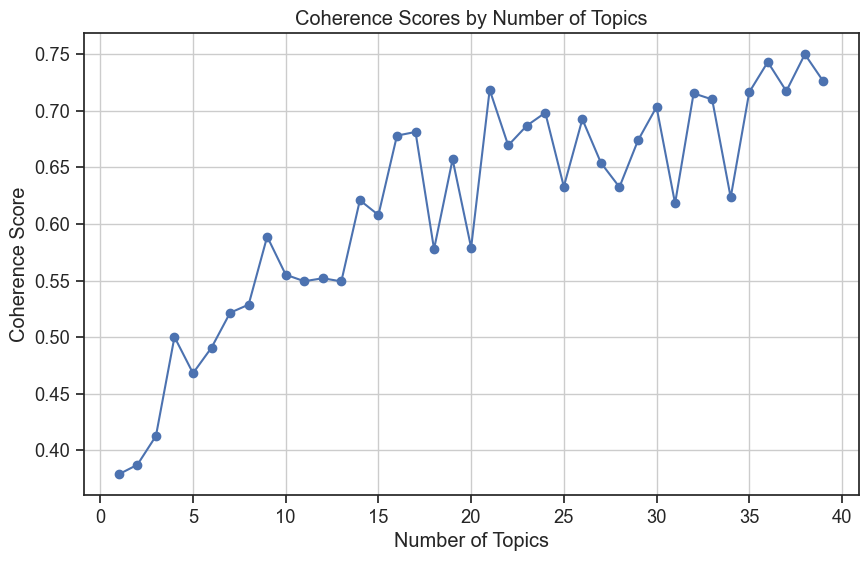

In [157]:


def plot_coherence_scores(loaded_model, num_topics_range, iterations=100):
    """
    Compute and plot coherence scores for different numbers of topics using the provided model.

    Parameters:
    loaded_model: The loaded LDA model.
    num_topics_range (list of int): List of numbers of topics to evaluate.
    iterations (int): Number of training iterations for each number of topics.

    Returns:
    list: Coherence scores for each number of topics.
    """
    coherence_scores = []

    for num_topics in num_topics_range:
        # Initialize the model with the new number of topics
        temp_model = tp.LDAModel(k=num_topics)
        
        # Add documents to the temporary model
        for doc in model.docs:
            temp_model.add_doc([model.vocabs[w] for w in doc.words])
        
        # Train the temporary model
        temp_model.train(iterations)

        # Compute the coherence score for the current number of topics
        coh = tp.coherence.Coherence(temp_model, coherence='c_v')
        coherence_score = coh.get_score()
        coherence_scores.append(coherence_score)
        
        print(f'Number of Topics: {num_topics}, Coherence Score: {coherence_score}')

    # Plot coherence scores
    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.title('Coherence Scores by Number of Topics')
    plt.grid(True)
    plt.show()

    return coherence_scores



# Define the range of number of topics to evaluate
num_topics_range = list(range(1, 40))

# Plot coherence scores
coherence_scores = plot_coherence_scores(model, num_topics_range, iterations =100)




### Topic Distributions and insights from the documents

In [161]:
#get topic distributions
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]


In [162]:
# Verify lengths
print(f"Length of topic_distributions: {len(topic_distributions)}")
print(f"Length of df_cleaned: {len(df_cleaned)}")

Length of topic_distributions: 5198
Length of df_cleaned: 5198


Top documents for political topics that I manually categorize as such. 

In [163]:

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, topics, n=5):
    """
    Get the top n documents for a given topic index with topic words highlighted.

    :param docs: List of document texts.
    :param topic_distributions: List of topic distributions for each document.
    :param topic_index: The index of the topic.
    :param topics: List of topics where each topic is a string of topic words.
    :param n: Number of top documents to return.
    :return: DataFrame with top documents for the topic.
    """
    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    topic_words = topics[topic_index]

    results = []
    unique_docs = set()
    count = 0

    for probability, doc in sorted_data:
        normalized_doc = re.sub(r'\W+', ' ', doc.lower()).strip()
        if normalized_doc not in unique_docs:
            unique_docs.add(normalized_doc)
            count += 1

            # Make topic words bolded
            highlighted_doc = doc
            for word in topic_words.split():
                if word in highlighted_doc.lower():
                    highlighted_doc = re.sub(f"\\b{word}\\b", f"**{word}**", highlighted_doc, re.IGNORECASE)

            results.append({
                'Topic': topic_index,
                'Topic Words': topic_words,
                'Probability': probability,
                'Document': highlighted_doc
            })

            if count >= n:
                break

    return pd.DataFrame(results)

In [164]:
# Get top documents for multiple topics
top_docs_dfs = []
for topic_index in [18, 19, 20]:  # Political topics
    top_docs_df = get_top_docs(original_texts, topic_distributions, topic_index, topics, n=3)
    top_docs_dfs.append(top_docs_df)

# Concatenate results into a single DataFrame
all_top_docs_df = pd.concat(top_docs_dfs, ignore_index=True)

# Display the DataFrame
all_top_docs_df

,Topic,Topic Words,Probability,Document
0,18,man country character party spirit men conduct...,0.730606,Sir Quincy August 15th 1804 Your Letter of Jul...
1,18,man country character party spirit men conduct...,0.724037,Sir Quincy August 18th 1804 Your Letter of Jul...
2,18,man country character party spirit men conduct...,0.715136,Sir Quincy August 18th 1804 your Letter of Jul...
3,19,washington excellency honor respect servt libe...,0.698246,Major General Hamilton— Sir West Chester Penns...
4,19,washington excellency honor respect servt libe...,0.655208,"[Albany, August 3, 1791. On August 10, 1791, H..."
5,19,washington excellency honor respect servt libe...,0.643487,Major General Hamilton —— Sir West Chester Sep...
6,20,country people war peace america nation men li...,0.415002,My dear Sister Quincy Feb’ry 26th 1815 your Le...
7,20,country people war peace america nation men li...,0.349230,"My dear Sister, Quincy Febry 28th 1815 Your Le..."
8,20,country people war peace america nation men li...,0.330501,"Dear Sir October 30, 1777 A favourable opportu..."


In [98]:
all_top_docs_df.to_csv('political_docs.csv')

In [176]:
get_top_docs(original_texts, topic_distributions, topic_index=8, topics=topics, n=3)

,Topic,Topic Words,Probability,Document
0,8,god wee wich president grate der work das van ...,0.865925,[21 March 1795] Dona Maria por graça de Deos R...
1,8,god wee wich president grate der work das van ...,0.781301,"Philadelphia, Octr 14, 1803 Gottes gnade und s..."
2,8,god wee wich president grate der work das van ...,0.532912,Exmo Sor Havana 6 de Julio de 1780 Mui Sor mio...


In [177]:
get_top_docs(original_texts, topic_distributions, topic_index=9, topics=topics, n=3)

,Topic,Topic Words,Probability,Document
0,9,addressed paris excellency london beg servant ...,0.631292,Sir Callais 10 Febr 1777 After Your goodness t...
1,9,addressed paris excellency london beg servant ...,0.630890,"Hotel d’Yorcke. [before February 2, 1783] Miss..."
2,9,addressed paris excellency london beg servant ...,0.592554,"Paris, Octr. 6th: 1783— Mrs. Montgomery & Son,..."


In [182]:
get_top_docs(original_texts, topic_distributions, topic_index=18, topics=topics, n=10)

,Topic,Topic Words,Probability,Document
0,18,man country character party spirit men conduct...,0.730606,Sir Quincy August 15th 1804 Your Letter of Jul...
1,18,man country character party spirit men conduct...,0.724037,Sir Quincy August 18th 1804 Your Letter of Jul...
2,18,man country character party spirit men conduct...,0.715136,Sir Quincy August 18th 1804 your Letter of Jul...
3,18,man country character party spirit men conduct...,0.533167,Sir Quincy July 1st 1804 your Letter of June 1...
4,18,man country character party spirit men conduct...,0.505167,Sir Quincy July 1st 1804 your Letter of June 1...
5,18,man country character party spirit men conduct...,0.391934,Sir Quincy October 25 1804 Sickness for three ...
6,18,man country character party spirit men conduct...,0.355978,"June 29th 1813— I am myself, my dear Madam, in..."
7,18,man country character party spirit men conduct...,0.335071,Sir Quincy october.25.1804 Sickness for three ...
8,18,man country character party spirit men conduct...,0.260035,Plymouth May 1798 Your ready reply my dear Mad...
9,18,man country character party spirit men conduct...,0.252694,Plimouth May 26th 1798 Your ready reply my dea...


In [184]:
get_top_docs(original_texts, topic_distributions, topic_index=19, topics=topics, n=6)

,Topic,Topic Words,Probability,Document
0,19,washington excellency honor respect servt libe...,0.698246,Major General Hamilton— Sir West Chester Penns...
1,19,washington excellency honor respect servt libe...,0.655208,"[Albany, August 3, 1791. On August 10, 1791, H..."
2,19,washington excellency honor respect servt libe...,0.643487,Major General Hamilton —— Sir West Chester Sep...
3,19,washington excellency honor respect servt libe...,0.637115,"Letter not found: from Margaret Savage, 10 Dec..."
4,19,washington excellency honor respect servt libe...,0.633533,"Letter not found: from Col. Ann Hawkes Hay, 30..."
5,19,washington excellency honor respect servt libe...,0.633533,"Letter not found: from Col. Ann Hawkes Hay, 2 ..."


In [185]:
get_top_docs(original_texts, topic_distributions, topic_index=20, topics=topics, n=6)

,Topic,Topic Words,Probability,Document
0,20,country people war peace america nation men li...,0.415002,My dear Sister Quincy Feb’ry 26th 1815 your Le...
1,20,country people war peace america nation men li...,0.349230,"My dear Sister, Quincy Febry 28th 1815 Your Le..."
2,20,country people war peace america nation men li...,0.330501,"Dear Sir October 30, 1777 A favourable opportu..."
3,20,country people war peace america nation men li...,0.327937,My Dear Madam June 15 1798 You and I my dear M...
4,20,country people war peace america nation men li...,0.319841,My dear Son Sepbr 7th 1814 I wrote to you on t...
5,20,country people war peace america nation men li...,0.318219,My Dear Son Quincy Sep’br 7th 1814 upon the 26...


Top authors associated with a topic.

In [165]:
import numpy as np

def get_top_unique_authors(titles, topic_distributions, topic_index=8, n=20):
    """
    Retrieve the top n unique authors most associated with a given topic.

    Parameters:
    titles (list): List of document authors.
    topic_distributions (list of lists or array-like): Topic distribution for each document.
    topic_index (int): Index of the topic of interest.
    n (int): Number of top unique authors to retrieve.

    Returns:
    list: Top n unique authors most associated with the specified topic.
    """
    # Convert topic_distributions to a NumPy array if it isn't one already
    topic_distributions = np.array(topic_distributions)
    
    # Extract the topic distribution for the specified topic
    topic_scores = topic_distributions[:, topic_index]
    
    # Get the indices of the documents sorted by topic score
    sorted_doc_indices = topic_scores.argsort()[::-1]
    
    unique_authors = []
    seen_authors = set()
    
    for i in sorted_doc_indices:
        author = titles[i]
        if author not in seen_authors:
            unique_authors.append(author)
            seen_authors.add(author)
        if len(unique_authors) == n:
            break
    
    return unique_authors




In [183]:
# Retrieve top unique authors for topic index 3 (adjust index as needed)
unique_authors = get_top_unique_authors(titles, topic_distributions, topic_index=9, n=5)

print("Top Unique Authors:", unique_authors)

Top Unique Authors: ['Adams, Abigail Smith', 'Warren, Mercy', 'Powel, Elizabeth Willing', 'Adams, Abigail', 'Senf, Gertrude J.']


In [167]:
# Retrieve top unique authors for topic index 3 (adjust index as needed)
unique_authors = get_top_unique_authors(titles, topic_distributions, topic_index=19, n=5)

print("Top Unique Authors:", unique_authors)

Top Unique Authors: ['Clemson, Eli B.', 'Hamilton, Elizabeth Schuyler', 'Savage, Margaret', 'Hay, Ann Hawkes', 'Dagworthy, Mary']


In [168]:
# Retrieve top unique authors for topic 
unique_authors = get_top_unique_authors(titles, topic_distributions, topic_index=18, n=5)

print("Top Unique Authors:", unique_authors)

Top Unique Authors: ['Adams, Abigail Smith', 'Adams, Abigail', 'Wright, Patience', 'Huntingdon, Selena Hastings, countess of', 'Van Winter, Lucretia Wilhelmina']


Plot trends of topics to see changes before and after the Revolutionary War.

Madison Presidency         863
Revolutionary War          778
post-Madison Presidency    743
Confederation Period       651
Adams Presidency           648
Washington Presidency      637
Jefferson Presidency       588
Colonial                   290
Name: period, dtype: int64


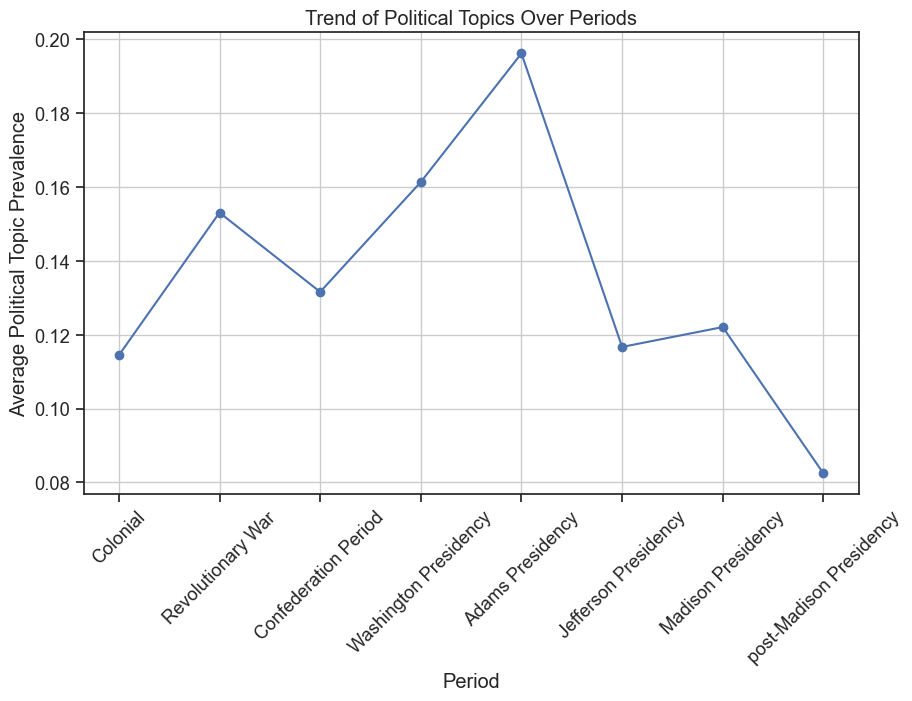

In [195]:

# Step 1: Categorize Topics 
political_topics = [18, 19,  20, 23, 29]

# Step 2: Calculate political scores
# Verify topic distributions and calculate political scores accurately
df_cleaned['political_score'] = [sum([topic_dist[i] for i in political_topics]) for topic_dist in topic_distributions]

# Step 3: Define the correct order of periods
period_order = ["Colonial", "Revolutionary War", "Confederation Period", "Washington Presidency", "Adams Presidency", "Jefferson Presidency", "Madison Presidency", "post-Madison Presidency"]
df_cleaned['period'] = pd.Categorical(df_cleaned['period'], categories=period_order, ordered=True)

# Verify if there are documents in each period
print(df_cleaned['period'].value_counts())

# Step 4: Group by period and calculate average political topic prevalence
period_political_trends = df_cleaned.groupby('period')['political_score'].mean().reindex(period_order).reset_index()

# Plot the trend of political topics over periods
plt.figure(figsize=(10, 6))
plt.plot(period_political_trends['period'], period_political_trends['political_score'], marker='o')
plt.xlabel('Period')
plt.ylabel('Average Political Topic Prevalence')
plt.title('Trend of Political Topics Over Periods')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Madison Presidency         863
Revolutionary War          778
post-Madison Presidency    743
Confederation Period       651
Adams Presidency           648
Washington Presidency      637
Jefferson Presidency       588
Colonial                   290
Name: period, dtype: int64


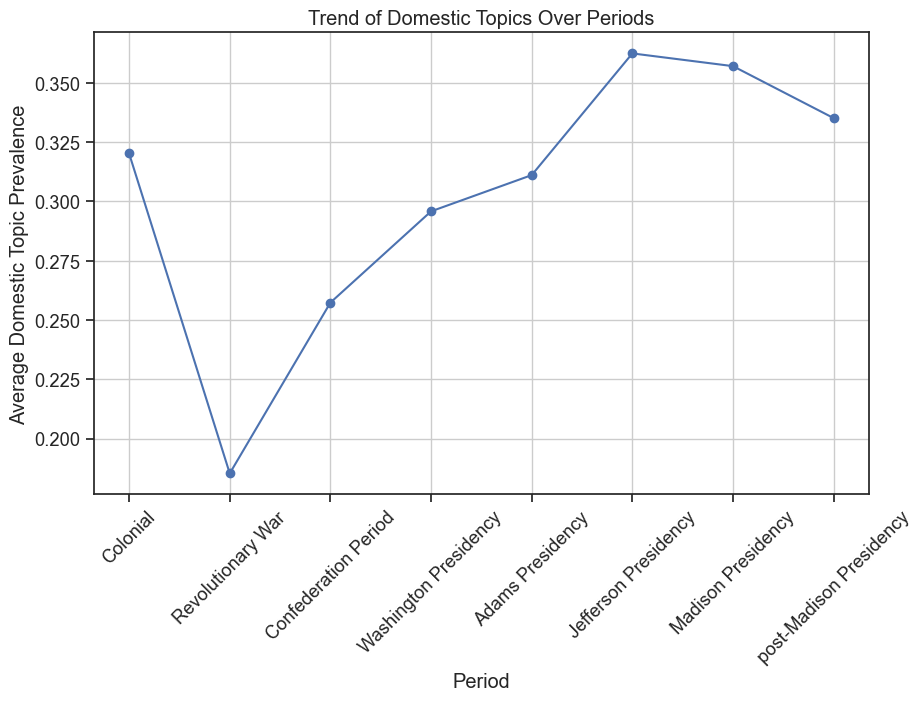

In [172]:
# Step 1: Categorize Topics 
domestic_topics = [0, 1, 2, 3, 4, 5, 6, 15, 16, 24, 25, 27, 28, 35, 36, 37]

# Step 2: Calculate political scores
# Verify topic distributions and calculate political scores accurately
df_cleaned['domestic_score'] = [sum([topic_dist[i] for i in domestic_topics]) for topic_dist in topic_distributions]

# Step 3: Define the correct order of periods
period_order = ["Colonial", "Revolutionary War", "Confederation Period", "Washington Presidency", "Adams Presidency", "Jefferson Presidency", "Madison Presidency", "post-Madison Presidency"]
df_cleaned['period'] = pd.Categorical(df_cleaned['period'], categories=period_order, ordered=True)

# Verify if there are documents in each period
print(df_cleaned['period'].value_counts())

# Step 4: Group by period and calculate average political topic prevalence
period_domestic_trends = df_cleaned.groupby('period')['domestic_score'].mean().reindex(period_order).reset_index()

# Plot the trend of political topics over periods
plt.figure(figsize=(10, 6))
plt.plot(period_domestic_trends['period'], period_domestic_trends['domestic_score'], marker='o')
plt.xlabel('Period')
plt.ylabel('Average Domestic Topic Prevalence')
plt.title('Trend of Domestic Topics Over Periods')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Madison Presidency         863
Revolutionary War          778
post-Madison Presidency    743
Confederation Period       651
Adams Presidency           648
Washington Presidency      637
Jefferson Presidency       588
Colonial                   290
Name: period, dtype: int64


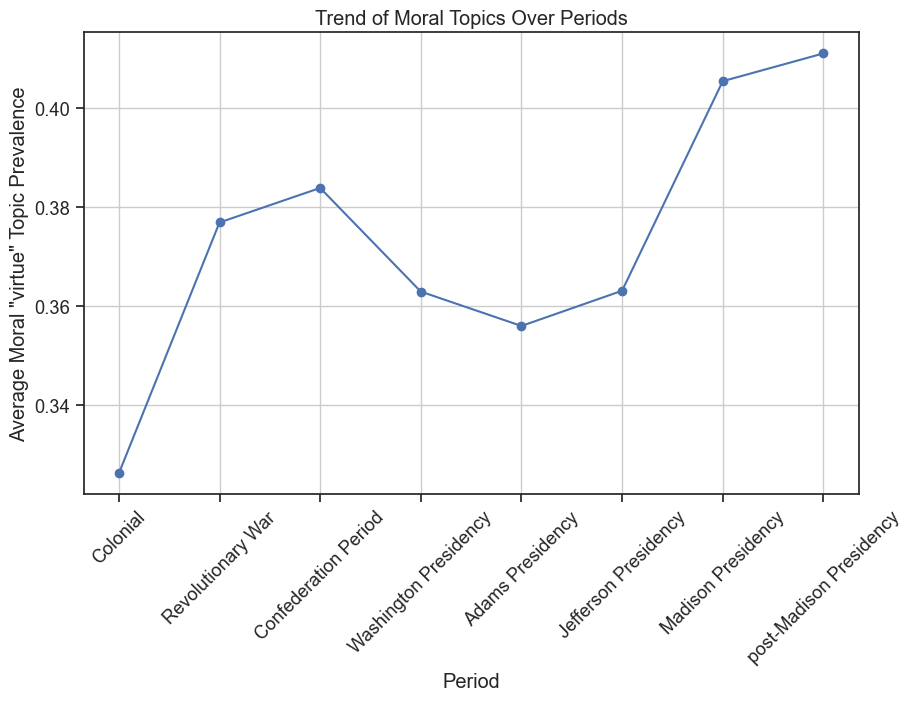

In [187]:
# Step 1: Categorize Topics 
moral_topics = [7, 10, 12, 13, 17, 21]

# Step 2: Calculate  scores
# Verify topic distributions and calculate scores accurately
df_cleaned['moral_score'] = [sum([topic_dist[i] for i in moral_topics]) for topic_dist in topic_distributions]

# Step 3: Define the correct order of periods
period_order = ["Colonial", "Revolutionary War", "Confederation Period", "Washington Presidency", "Adams Presidency", "Jefferson Presidency", "Madison Presidency", "post-Madison Presidency"]
df_cleaned['period'] = pd.Categorical(df_cleaned['period'], categories=period_order, ordered=True)

# Verify if there are documents in each period
print(df_cleaned['period'].value_counts())

# Step 4: Group by period and calculate average moral topic prevalence
period_moral_trends = df_cleaned.groupby('period')['moral_score'].mean().reindex(period_order).reset_index()

# Plot the trend of moral topics over periods
plt.figure(figsize=(10, 6))
plt.plot(period_moral_trends['period'], period_moral_trends['moral_score'], marker='o')
plt.xlabel('Period')
plt.ylabel('Average Moral "virtue" Topic Prevalence')
plt.title('Trend of Moral Topics Over Periods')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Madison Presidency         863
Revolutionary War          778
post-Madison Presidency    743
Confederation Period       651
Adams Presidency           648
Washington Presidency      637
Jefferson Presidency       588
Colonial                   290
Name: period, dtype: int64


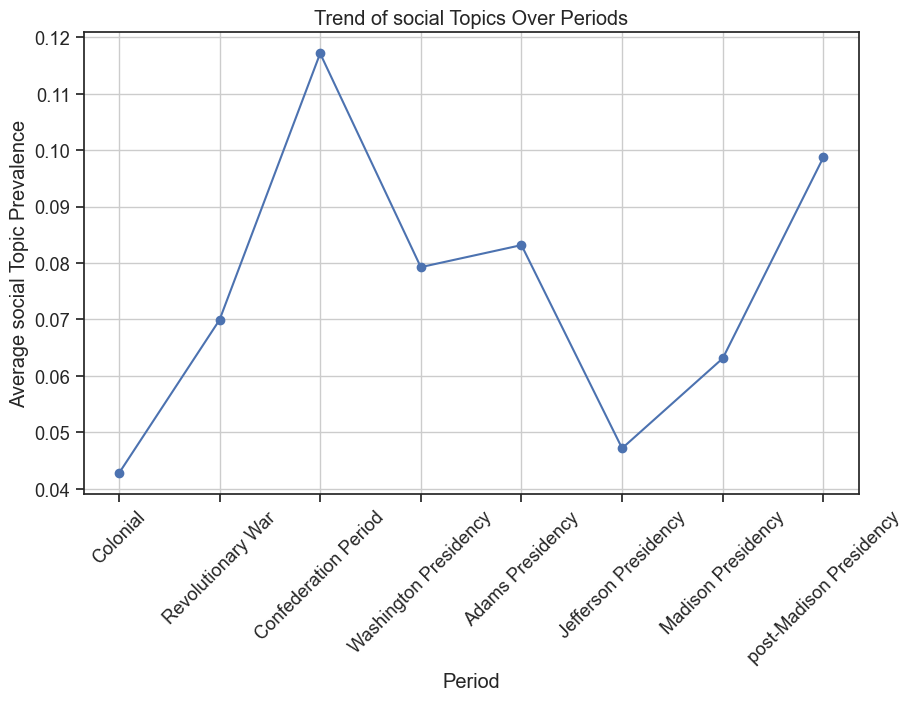

In [188]:
# Step 1: Categorize Topics 
social_topics = [14, 22, 26, 34]

# Step 2: Calculate political scores
# Verify topic distributions and calculate political scores accurately
df_cleaned['social_score'] = [sum([topic_dist[i] for i in social_topics]) for topic_dist in topic_distributions]

# Step 3: Define the correct order of periods
period_order = ["Colonial", "Revolutionary War", "Confederation Period", "Washington Presidency", "Adams Presidency", "Jefferson Presidency", "Madison Presidency", "post-Madison Presidency"]
df_cleaned['period'] = pd.Categorical(df_cleaned['period'], categories=period_order, ordered=True)

# Verify if there are documents in each period
print(df_cleaned['period'].value_counts())

# Step 4: Group by period and calculate average political topic prevalence
period_social_trends = df_cleaned.groupby('period')['social_score'].mean().reindex(period_order).reset_index()

# Plot the trend of political topics over periods
plt.figure(figsize=(10, 6))
plt.plot(period_social_trends['period'], period_social_trends['social_score'], marker='o')
plt.xlabel('Period')
plt.ylabel('Average social Topic Prevalence')
plt.title('Trend of social Topics Over Periods')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()